In [40]:
import random
import math


def normal_sample_clt(mean: float, disp: float) -> float:
    """ Generates sample with normal distribution using central limit theorem """

    uniform_sum = sum(random.random() for _ in range(12))
    standard_normal = uniform_sum - 6
    return mean + disp * standard_normal

    
def normal_sample_rejection(mean, dispersion):
    """ Generates sample with normal distribution using rejection sampling """
    while True:
        x = 2 * random.random() - 1
        y = random.random()
        if y < math.exp(-x**2 / 2):
            return mean + dispersion * x


def normal_sample_box_muller(mean: float, disp: float) -> float:
    """ Generates sample with normal distribution using Box-Muller transform """
    u1 = random.random()
    u2 = random.random()

    while u1 == 0:
        u1 = random.random()

    z0 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    return mean + disp * z0


====== normal_sample_clt ======
Average time: 700.58 ns/sample
Target mean: 0.00, Sample mean: 0.03
Target std: 5.00, Sample std: 4.98
Target var: 25.00, Sample var: 24.82


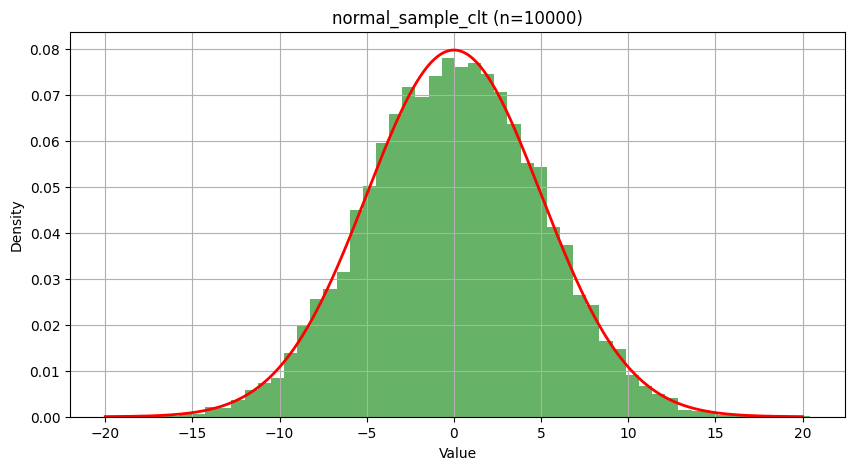


====== normal_sample_rejection ======
Average time: 230.76 ns/sample
Target mean: 0.00, Sample mean: 0.06
Target std: 5.00, Sample std: 2.68
Target var: 25.00, Sample var: 7.18


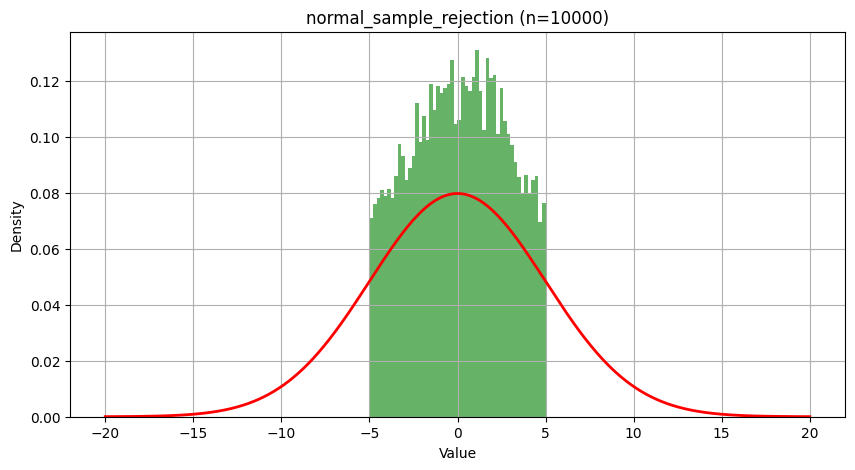


====== normal_sample_box_muller ======
Average time: 211.96 ns/sample
Target mean: 0.00, Sample mean: 0.05
Target std: 5.00, Sample std: 5.02
Target var: 25.00, Sample var: 25.19


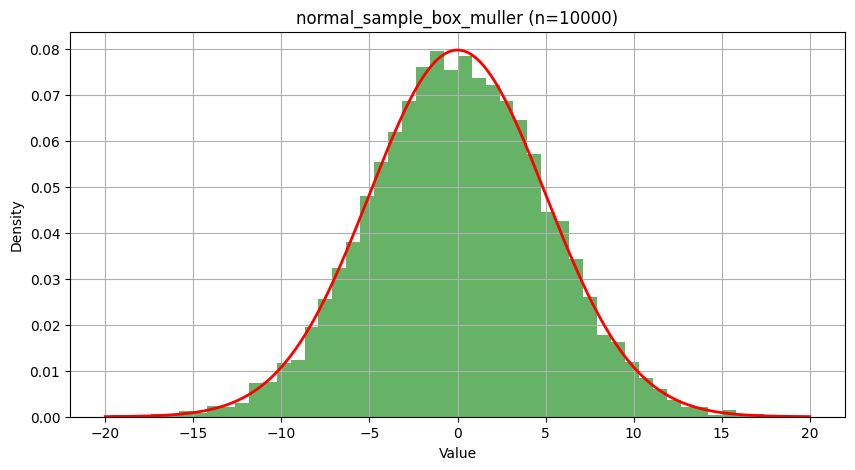


====== normal ======
Average time: 461.84 ns/sample
Target mean: 0.00, Sample mean: 0.09
Target std: 5.00, Sample std: 5.00
Target var: 25.00, Sample var: 25.01


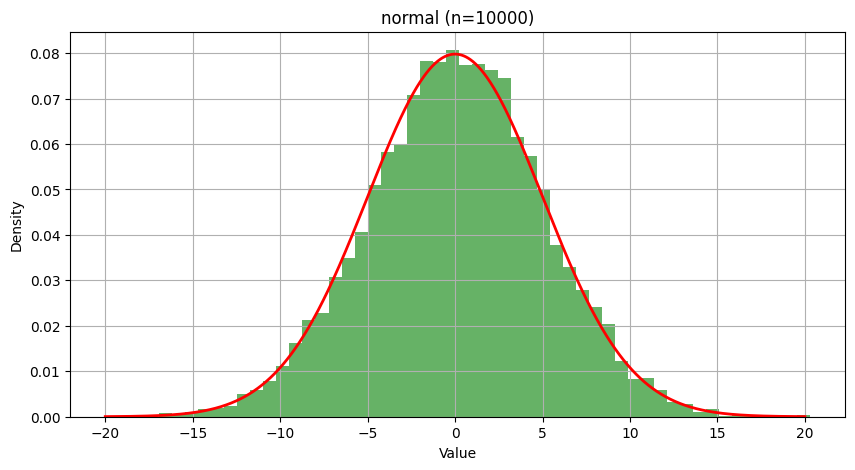

In [41]:
from matplotlib import pyplot as plt
from time import perf_counter_ns
import numpy as np
from scipy.stats import norm


def calculate_stats(samples):
    """Calculate statistics without scipy"""
    n = len(samples)
    mean = sum(samples)/n
    variance = sum((x-mean)**2 for x in samples)/n
    std_dev = math.sqrt(variance)
    return mean, variance, std_dev


def test_sampling_algo(rng_algo, mean=0, disp=5, num_samples=10000):
    samples = []
    
    start = perf_counter_ns()
    for _ in range(num_samples):
        samples.append(rng_algo(mean, disp))
    elapsed_ns = perf_counter_ns() - start
    
    sample_mean, sample_var, sample_std = calculate_stats(samples)
    
    print(f"\n====== {rng_algo.__name__} ======")
    print(f"Average time: {elapsed_ns/num_samples:.2f} ns/sample")
    print(f"Target mean: {mean:.2f}, Sample mean: {sample_mean:.2f}")
    print(f"Target std: {disp:.2f}, Sample std: {sample_std:.2f}")
    print(f"Target var: {disp**2:.2f}, Sample var: {sample_var:.2f}")
    
    plt.figure(figsize=(10, 5))
    
    hist, bins, _ = plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')
    x = np.linspace(mean - 4*disp, mean + 4*disp, 1000)
    pdf = [norm.pdf(val, mean, disp) for val in x]
    plt.plot(x, pdf, 'r-', lw=2)
    
    plt.title(f"{rng_algo.__name__} (n={num_samples})")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    

test_sampling_algo(normal_sample_clt)
test_sampling_algo(normal_sample_rejection)
test_sampling_algo(normal_sample_box_muller)
test_sampling_algo(np.random.normal)


In [42]:
import glm
import math


def sample_motion_model(u: glm.vec3, pos: glm.vec3, noise: glm.vec4) -> glm.vec3:
    delta_r1 = u.x + normal_sample_box_muller(0, noise[0] * abs(u.x) + noise[1] * u.z)
    delta_r2 = u.y + normal_sample_box_muller(0, noise[0] * abs(u.y) + noise[1] * u.z)
    delta_trans = u.z + normal_sample_box_muller(0, noise[2] * u.z + noise[3] * (abs(u.x) + abs(u.y)))
    
    pred_x = pos.x + delta_trans * math.cos(pos.z + delta_r1)
    pred_y = pos.y + delta_trans * math.sin(pos.z + delta_r1)
    pred_theta = pos.z + delta_r1 + delta_r2
    return glm.vec3(pred_x, pred_y, pred_theta)

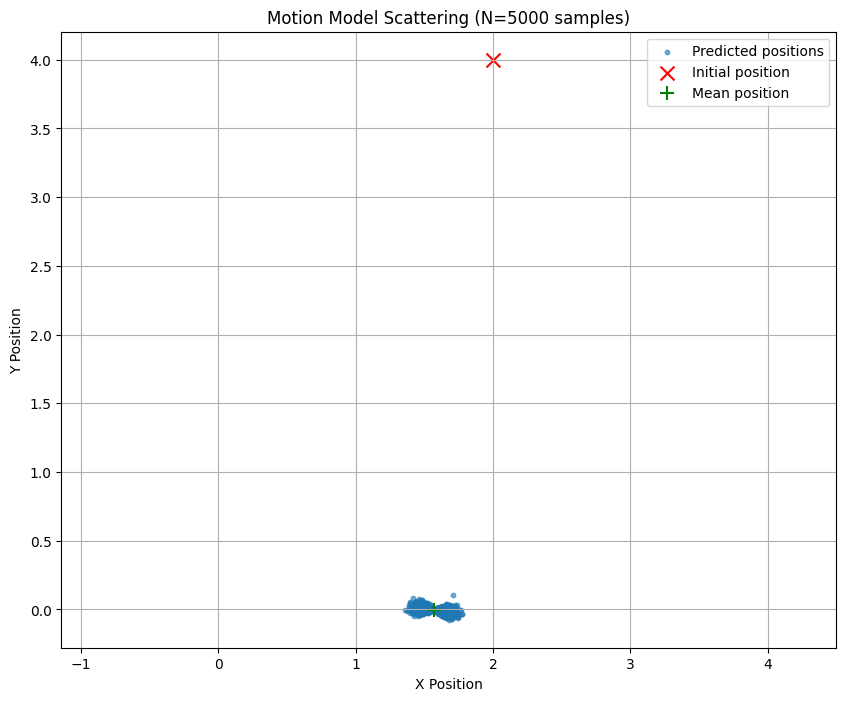

In [43]:
pos = glm.vec3(
    2.0,
    4.0,
    0.0
)
u = glm.vec3(
    math.pi / 2,
    0.0,
    1.0
)
noise = (
    0.1,
    0.1,
    0.01,
    0.01
)
N = 5000

points = []
for _ in range(N):
    points.append(sample_motion_model(pos, u, noise))
points = np.array(points)

plt.figure(figsize=(10, 8))
    
plt.scatter(points[:, 0], points[:, 1], alpha=0.6, s=10, label='Predicted positions')

plt.scatter(pos.x, pos.y, c='red', s=100, marker='x', label='Initial position')

mean_x, mean_y, _ = np.mean(points, axis=0)
plt.scatter(mean_x, mean_y, c='green', s=100, marker='+', label='Mean position')

plt.title(f'Motion Model Scattering (N={N} samples)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()